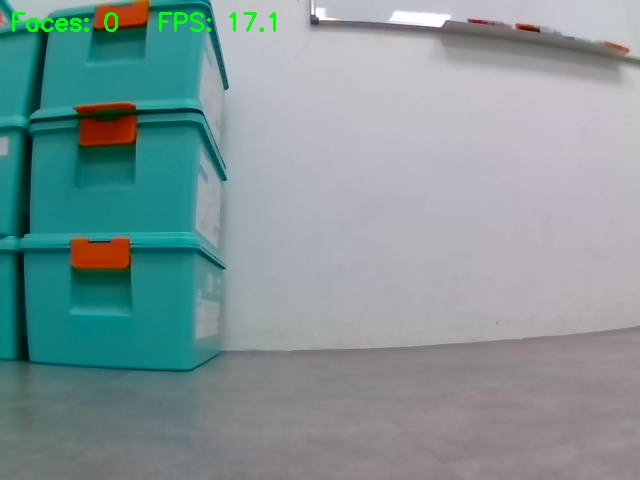

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import time
from IPython.display import display, clear_output, Image
from ugot import ugot

def main():
    got = ugot.UGOT()
    got.initialize('192.168.1.217')
    got.open_camera()

    # Load Haar cascade
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    if face_cascade.empty():
        print("Error: could not load Haar cascade for face detection.")
        return

    prev_time = time.time()
    fps = 0.0

    # --- Minimum detectable face size ---
    MIN_FACE_WIDTH  = 80
    MIN_FACE_HEIGHT = 80

    while True:
        frame = got.read_camera_data()
        if frame is None or len(frame) == 0:
            print("Failed to grab frame")
            break

        # Decode JPEG
        nparr = np.frombuffer(frame, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        if img is None:
            print("Failed to decode frame")
            break

        # --- FPS calculation ---
        now = time.time()
        dt = now - prev_time
        prev_time = now
        if dt > 0:
            fps = 0.9 * fps + 0.1 * (1.0 / dt)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces
        detected = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )

        # Filter based on size
        faces = [
            (x, y, w, h) for (x, y, w, h) in detected
            if w >= MIN_FACE_WIDTH and h >= MIN_FACE_HEIGHT
        ]

        # Draw boxes
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h),
                          (0, 255, 0), 2)
            cv2.putText(img, f"{w}x{h}",
                        (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6,
                        (0, 255, 0), 2)

        # Overlay info
        info = f"Faces: {len(faces)}   FPS: {fps:.1f}"
        cv2.putText(img, info, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                    (0, 255, 0), 2)

        # --- DISPLAY INLINE ---
        _, jpeg = cv2.imencode('.jpg', img)
        clear_output(wait=True)
        display(Image(data=jpeg.tobytes()))

        time.sleep(0.03)  # smoothness + CPU reduction

    print("Stopped.")


main()
